## Load and Explore  Labels Data

In [1]:
#Import labeled data downloaded from : http://gapfinder-tools.wmflabs.org/admin/sectionalignment/userinput/
#A copy of can be downlodaded from: ADD GITHUB LINK HERE
import pandas as pd

labels = pd.read_csv('SectionTranslationLabels.tsv',sep='\t')
labels['destination_title'] = labels.destination_title.map(eval) #transform string to list

In [59]:
total = 0
for src,data in labels.groupby(labels.source_lang):
    for dest,data2 in data.groupby('destination_language'):
        print(src,dest,len(data2))
        total+=len(data2)

ar en 544
ar es 87
ar fr 276
ar ja 11
ar ru 27
en ar 473
en es 999
en fr 999
en ja 698
en ru 947
es ar 3
es en 526
es fr 500
es ja 1
es ru 19
fr ar 42
fr en 529
fr es 142
fr ja 76
fr ru 52
ja en 100
ja es 10
ja fr 77
ru ar 3
ru en 418
ru es 18
ru fr 332
ru ja 37


In [3]:
labels

,source_lang,source_title,destination_language,destination_title,user_session_key
0,ru,Родились,ja,[出自],1hl2ay9d01lek5piry4jjqvj377xwmh7
1,ru,Этимология,ja,[由来],1hl2ay9d01lek5piry4jjqvj377xwmh7
2,ru,Комментарии,ja,[註釈],1hl2ay9d01lek5piry4jjqvj377xwmh7
3,ru,Культура,ja,[文化],1hl2ay9d01lek5piry4jjqvj377xwmh7
4,ru,Источник,ja,[出典],1hl2ay9d01lek5piry4jjqvj377xwmh7
5,ru,Турнирная таблица,ja,[順位表],1hl2ay9d01lek5piry4jjqvj377xwmh7
6,ru,Медалисты,ja,"[受賞者, メダリスト]",1hl2ay9d01lek5piry4jjqvj377xwmh7
7,ru,Города-побратимы,ja,[姉妹都市],1hl2ay9d01lek5piry4jjqvj377xwmh7
8,ru,Улицы,ja,"[道路, 通り]",1hl2ay9d01lek5piry4jjqvj377xwmh7
9,ru,Расположение,ja,"[位置, 場所]",1hl2ay9d01lek5piry4jjqvj377xwmh7


In [4]:
### Exploid multiple translatios
df = labels.set_index(['source_lang', 'source_title','destination_language'])['destination_title'].apply(pd.Series).stack()
df = df.reset_index()
del(df['level_3'])
df.rename(columns={0:'destination_title'},inplace=True)
df.set_index('source_lang',inplace=True)
labelsExploid = df.reset_index() 

In [5]:
total = 0
for src,data in df.groupby(df.index):
    for dest,data2 in data.groupby('destination_language'):
        print(src,dest,len(data2))
        total+=len(data2)
print(total)

ar en 565
ar es 87
ar fr 285
ar ja 21
ar ru 29
en ar 543
en es 1062
en fr 1210
en ja 1169
en ru 1178
es ar 3
es en 569
es fr 522
es ja 2
es ru 19
fr ar 43
fr en 746
fr es 155
fr ja 162
fr ru 64
ja en 129
ja es 12
ja fr 105
ru ar 3
ru en 460
ru es 19
ru fr 346
ru ja 41
9549


## Classification 

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import editdistance
translations =pd.read_pickle('translations.p')

def getCosineSim(A,B): #Avoiding cosine_similarty problems with Nan and Series shape
    A = A.values.reshape(1,A.shape[0])
    B = B.values.reshape(1,B.shape[0])

    try:   return cosine_similarity(A,B)[0][0]
    except: return 0 
    
def balanceDF(df,column,ratio,valToKeep):
    '''
    Receive dataframe with a Binary column and return a subset 
    balanced in that column acording to ratio
    valToKeep value to keep
    '''
    minCol  = min(df[column].value_counts())
    rowsToKeep = df[df[column] == valToKeep]
    df = df.sample(minCol*ratio,random_state=5)
    return pd.concat([df,rowsToKeep])

def prepareDataNew(langFrom,langTo,AutomaticTranslation=True):
    global labelsExploid
    labelsPair = labelsExploid[(labelsExploid['source_lang'] == langFrom) & (labelsExploid['destination_language'] ==langTo )][['source_title','destination_title']]
    labeledSec = labelsPair.source_title.unique()
    try:
        distances = pd.read_pickle('FastTextDistances/distances_%s_%s.p' % (langFrom,langTo))
    except:
        distances = pd.read_pickle('FastTextDistances/distances_%s_%s.p' % (langTo,langFrom))
    try:
        mydistances = pd.read_pickle('FastTextDistances-my_alingments/distances_%s_%s.p' % (langFrom,langTo))
    except:
        mydistances = pd.read_pickle('FastTextDistances-my_alingments/distances_%s_%s.p' % (langTo,langFrom))
    try:
        linkdistances = pd.read_pickle('linksSimilarities/%s_%s.p' % (langFrom,langTo))
    except:
        linkdistances = pd.read_pickle('linksSimilarities/%s_%s.p' % (langTo,langFrom))
    try:
        contentdistances = pd.read_pickle('fastTextContentSimilarities/%s_%s.p' % (langTo,langFrom))
    except:
        contentdistances = pd.read_pickle('fastTextContentSimilarities/%s_%s.p' % (langFrom,langTo))

    ##langFrom is documents, LangTo is words,
    coOcurrences = pd.read_pickle('resultsMappingTfIdf/TfIDF_%s_%s.p' % (langFrom,langTo))
    #CLEANING NOISE, THIS SHOULD BE DONE BEFORE
    coOcurrences =  coOcurrences[~coOcurrences[langFrom].str.contains('\[|{|"')]  #Cleaning sections with links
    coOcurrences =  coOcurrences[~coOcurrences[langTo].str.contains('\[|{|"')]  #Cleaning sections with links

    features = pd.merge(distances, coOcurrences,  how='inner', 
                        left_on=[langFrom,langTo], right_on = [langFrom,langTo])
    features = features[features[langFrom].isin(labeledSec)]
    features = pd.merge(features, mydistances,  how='inner', 
                        left_on=[langFrom,langTo], right_on = [langFrom,langTo],suffixes=['','_my']) 
    features = pd.merge(features, contentdistances,  how='inner', 
                        left_on=[langFrom,langTo], right_on = [langFrom,langTo])
    features = pd.merge(features, linkdistances,  how='inner', 
                        left_on=[langFrom,langTo], right_on = [langFrom,langTo])
    features = features[features[langFrom].isin(labeledSec)]
    dataset = pd.merge(features, labelsPair[['source_title','destination_title']], how='left', left_on=[langFrom,langTo], right_on = ['source_title','destination_title'])#,'destination_title'])
                                
    dataset['isTranslation'] = dataset.destination_title.notna()
    dataset.rename(columns={langTo+'_tfidf':'LangTo_tfidf',langFrom+'_tfidf':'LangFrom_tfidf',langFrom:'langFrom',langTo:'langTo'},inplace=True)
    del(dataset['source_title'])
    del(dataset['destination_title'])
    secsFrom = pd.read_pickle('SectionsCharacterization/sections-articles_%s.p' % langFrom )
    secsTo = pd.read_pickle('SectionsCharacterization/sections-articles_%s.p' % langTo )
    secsFromJoined = pd.merge(dataset, secsFrom, how='left', left_on='langFrom', right_on = secsFrom.index)#,'destination_title'])
    secsToJoined    = pd.merge(dataset, secsTo, how='left', left_on='langTo', right_on = secsTo.index,suffixes=('', '_langTo'))#,'destination_title'])
    colsSec = secsFrom.columns
    secDistSub  = secsFromJoined[colsSec] - secsToJoined[colsSec]
    secDistMult  = secsFromJoined[colsSec] * secsToJoined[colsSec]
    #Removing Cosine Similarity, take long time and it is not adding enough information

    #secsJoined = secsFromJoined[colsSec].join(secsToJoined[colsSec],rsuffix='_r')
    #dataset['DistCos'] = secsJoined.apply(lambda row: getCosineSim(row[cols],row[[c+'_r' for c in cols]]),axis=1)                                              
    dataset = dataset.join(secDistSub).join(secDistMult,rsuffix='_mult')
    dataset = dataset.join(secsFrom[['rank']],on='langFrom',rsuffix='_from')

    dataset['editDistance'] = dataset.apply(lambda x:editdistance.eval(x['langFrom'],x['langTo']) / max(len(x['langFrom']),len(x['langTo'])) ,axis=1)
    if AutomaticTranslation:
        trans = translations[(translations['source_lang'] == langFrom) & (translations['destination_language'] == langTo)][['source_title','automatic_translation']]
        dataset = pd.merge(dataset, trans, how='left', left_on='langFrom', right_on = 'source_title')#,'destination_title'])
        dataset['isAutomaticTranslationFrom'] = dataset['langTo'] == dataset['automatic_translation']
        del(dataset['source_title'])
        del(dataset['automatic_translation'])
        trans = translations[(translations['source_lang'] == langTo) & (translations['destination_language'] == langFrom)][['source_title','automatic_translation']]
        dataset = pd.merge(dataset, trans, how='left', left_on='langTo', right_on = 'source_title')#,'destination_title'])
        dataset['isAutomaticTranslationTo'] = dataset['langFrom'] == dataset['automatic_translation']
        del(dataset['source_title'])
        del(dataset['automatic_translation'])
    #Scaling to one 
    dataset['count_normed']  = dataset['count'] / dataset['count'].max()
    dataset['LangFrom_tfidf_normed']  = dataset['LangFrom_tfidf'] / dataset['LangFrom_tfidf'].max()
    dataset['LangTo_tfidf_normed']  = dataset['LangTo_tfidf'] / dataset['LangTo_tfidf'].max()
    #ranks (relative position, instead of raw number, per word)
    dataset["rank_by_count"] = dataset.groupby("langFrom")["count"].rank("dense", ascending=False)
    dataset["rank_by_LangFrom_tfidf"] = dataset.groupby("langFrom")["LangFrom_tfidf"].rank("dense", ascending=False)
    dataset["rank_by_LangTo_tfidf"] = dataset.groupby("langFrom")["LangTo_tfidf"].rank("dense", ascending=False)

    #polinomial  / weighted 
    dataset['Distance_myWeighted']  = dataset['count_normed'] *  dataset['Distance_my']
    dataset['DistanceWeighted']  = dataset['count_normed'] *  dataset['Distance']
    dataset['LangFrom_tfidfWeighted']  = dataset['count_normed'] *  dataset['LangFrom_tfidf']
    dataset['LangTo_tfidfWeighted']  = dataset['count_normed'] *  dataset['LangTo_tfidf']
    return dataset

## Build datasets

In [10]:
from itertools import permutations
langs=['ru', 'ja', 'fr', 'ar','es', 'en']

finalResults = []
datasets = {}
for pair in permutations(langs,2):
        print(pair)
        try: #for avoiding error in empty pairs (ja,ru)
            tmpDF = prepareDataNew(pair[0],pair[1],AutomaticTranslation=True)
            if tmpDF.shape[0] > 1: #to deal with empty pairs
                datasets[pair[0]] = datasets.get(pair[0],{})
                datasets[pair[0]][pair[1]] = balanceDF(tmpDF,'isTranslation',2,True)
        except Exception as ex:
            print(ex)

('ru', 'ja')
('ru', 'fr')
('ru', 'ar')
('ru', 'es')
('ru', 'en')
('ja', 'ru')
Cannot set a frame with no defined index and a value that cannot be converted to a Series
('ja', 'fr')
('ja', 'ar')
Cannot set a frame with no defined index and a value that cannot be converted to a Series
('ja', 'es')
('ja', 'en')
('fr', 'ru')
('fr', 'ja')
('fr', 'ar')
('fr', 'es')
('fr', 'en')
('ar', 'ru')
('ar', 'ja')
('ar', 'fr')
('ar', 'es')
('ar', 'en')
('es', 'ru')
('es', 'ja')
('es', 'fr')
('es', 'ar')
('es', 'en')
('en', 'ru')
('en', 'ja')
('en', 'fr')
('en', 'ar')
('en', 'es')


### Get results without Automatic Translation

In [430]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from itertools import permutations
evaluate = True ### SET THIS TRUE TO EVAL RESULTS, SET NO IF YOU JUST WANT TO CREATE PREDICTIONS WITHOUT EVALUATION
K = 5
generateRecs = True # Generate XLS with rec examples
numbOfCandidates = 3 # This is the number of candidates in XLS
#features = ['LangTo_tfidf','LangFrom_tfidf','Distance','Distance_my',
#            'count','pos_norm_avg','pos_inv_avg','pos_norm_median',
#            'pos_avg_mult','size_median_mult','num_links_avg',
#           'links_jaccardMEAN', 'links_jaccardMEDIAN',
#           'links_jaccardSUM', 'links_commonMEAN', 'links_commonMEDIAN',
#           'links_commonSUM','editDistance','count_normed',
#            'Distance_myWeighted','DistanceWeighted','LangFrom_tfidfWeighted','LangTo_tfidfWeighted','rank']
            #'isAutomaticTranslationTo','isAutomaticTranslationFrom']
features = datasets['en']['es'].columns #could be any pair, all have the same columns
features = features.drop(['isTranslation','langFrom','langTo','isAutomaticTranslationTo','isAutomaticTranslationFrom'])

featuresRank = []
finalResults = []
accuracyPos = {}
for lang in langs:
    print(lang)
    tmpDF = []
    toPSL = [] # create Dataframe per language with predictions
    for lang1,data in datasets.items():
        if lang1 != lang:
            for lang2,dataset in data.items():
                if lang2 != lang:
                    tmpDF.append(dataset)    
    TrainData = pd.concat(tmpDF)
    X_train = TrainData[features]
    Y_train = TrainData['isTranslation']
    Model = XGBClassifier()
    Model.fit(X_train, Y_train)
    print(sorted(zip(Model.feature_importances_,X_train.columns),reverse=True))
    featuresRank.append(sorted(zip(Model.feature_importances_,X_train.columns),reverse=True))
    accuracyPos[lang] = {}
    for lang1,lang2 in permutations(langs,2):
        if lang1 == lang:
            try:
                recSheet = []
            
                TestData = prepareDataNew(lang1,lang2) # I need to create again the dataset, because the stored ones, are balanaced
                TestData  = TestData[TestData['count'] > 1] # PRE-FILTER, CANDIDATES NEWS TO COOCURR AT LEAST TWO (Arbitrary), THIS FOR REMOVING TYPOS AND NOISE

                X_test = TestData[features]
                test = TestData['isTranslation']
                y_prob= Model.predict_proba(X_test)
                TestData['prob'] = [pred[1] for pred in y_prob]
                ## CREATE PSL OUTPUT
                toPSLtmp = TestData[['langFrom','langTo','prob', 'Distance_my', 'links_jaccardMEAN',
       'rank', 'LangTo_tfidf_normed','LangTo_tfidfWeighted', 'editDistance','isTranslation']]
                toPSLtmp['langFrom'] = lang1 +'_' + toPSLtmp['langFrom'] 
                toPSLtmp['langTo'] = lang2 +'_' + toPSLtmp['langTo']                           
                toPSL.append(toPSLtmp)      

                if evaluate: ### SET THIS TRUE TO EVAL RESULTS, SET NO IF YOU JUST WANT TO CREATE PREDICTIONS WITHOUT EVALUATIO
                    output = []
                    automaticTranslation = []
                    #init accuracy dict
                    accjustEmbeddings = {}
                    accjustEmbeddingsMy = {}
                    accuracy = {}
                    accuracyPos[lang1][lang2] = {}          
                    for i in range(1,K+1,2):
                        accuracy[i] = []
                        accjustEmbeddings[i] = []
                        accjustEmbeddingsMy[i] = []
                        accuracyPos[lang1][lang2][i] = []

                    for secFrom,data in TestData.groupby('langFrom'):

                         if data['isTranslation'].any():
                            rank = data[TestData['isTranslation']]['rank_from'].iloc[0]
                            if data[TestData['isTranslation']]['isAutomaticTranslationFrom'].any() : #check if label is automatic translation
                                automaticTranslation.append(1)
                            else:
                                automaticTranslation.append(0)

                            for i in range(1,K+1,2):
                                #evaluation my approach
                                evaluation = data.sort_values('prob',ascending=False).iloc[0:i]['isTranslation'].any()

                                if evaluation:
                                    accuracy[i].append(1)
                                    accuracyPos[lang1][lang2][i].append((rank,1))

                                else:
                                    accuracy[i].append(0)
                                    accuracyPos[lang1][lang2][i].append((rank,0))
                                #evaluating just embeedings

                                evaluationjustEmbeddings = data.sort_values('Distance',ascending=False).iloc[0:i]['isTranslation'].any()
                                evaluationjustEmbeddingsMy = data.sort_values('Distance_my',ascending=False).iloc[0:i]['isTranslation'].any()

                                if evaluationjustEmbeddings:
                                    accjustEmbeddings[i].append(1)
                                else:
                                    accjustEmbeddings[i].append(0)

                                if evaluationjustEmbeddingsMy:
                                    accjustEmbeddingsMy[i].append(1)
                                else:
                                    accjustEmbeddingsMy[i].append(0)    

                                if generateRecs == True:
                                        if numbOfCandidates == i:
                                            candidates = data.sort_values('prob',ascending=False)[['langTo','prob','isTranslation','rank_from']].iloc[0:5]
                                            candidates['secFrom'] =secFrom
                                            recSheet.append(candidates)

                    numOfInstances= len(automaticTranslation)

                    if  numOfInstances> 0: #Here I'm just counting the number of sections with labels
                        acc = {'langFrom':lang1,'langTo':lang2,'Instances':numOfInstances}
                        acc['Baseline'] = round(sum(automaticTranslation)/len(automaticTranslation),2)
                        for i in range(1,K+1,2):
                            try:
                                acc['Acc@%s' % i] = round(sum(accuracy[i])/len(accuracy[i]),2)
                                acc['Baseline2 Acc@%s' % i] = round(sum(accjustEmbeddings[i])/len(accjustEmbeddings[i]),2)
                                acc['Baseline3 Acc@%s' % i] = round(sum(accjustEmbeddingsMy[i])/len(accjustEmbeddingsMy[i]),2)

                            except:
                                acc['Acc@%s' %i] = 0

                        print(lang1,lang2,acc)
                        finalResults.append(acc)
                        recSheet = pd.concat(recSheet)
                        recSheet.set_index('secFrom',inplace=True)
                        recSheet.sort_values(['rank_from','prob'],ascending=[True,False],inplace=True)
                        del(recSheet['rank_from'])
                        recSheet.to_excel('recSheets/%s_to_%s.xls' % (lang1,lang2))


            except Exception as ex:
                print('error',ex) #empty pairs


    toPSL = pd.concat(toPSL)
    toPSL = toPSL.rename(columns={'Distance_my':'Embeddings_similarity', 'links_jaccardMEAN':'Link_similarity',
       'rank':'rank_by_frequency', 'LangTo_tfidf_normed':'Coocurrence_TfIDF1','LangTo_tfidfWeighted':'Coocurrence_TfIDF2'})
    toPSL.to_csv('toPSL/%s.tsv' % lang,sep='\t',index=False)

    
#pd.DataFrame(finalResults).sort_values('langFrom').to_csv('predictorOutputWithoutAutomaticTranslationV2.csv')


ru


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.11312217, 'Distance_my'), (0.07692308, 'links_jaccardMEAN'), (0.0693816, 'LangTo_tfidf_normed'), (0.05882353, 'editDistance'), (0.043740574, 'LangTo_tfidfWeighted'), (0.04223228, 'Distance'), (0.040723983, 'rank'), (0.039215688, 'pos_norm_avg'), (0.033182506, 'links_jaccardSUM'), (0.030165913, 'pos_avg'), (0.028657617, 'pos_norm_avg_mult'), (0.02413273, 'pos_inv_avg'), (0.022624435, 'TotalCount'), (0.02111614, 'rank_by_count'), (0.02111614, 'LangTo_tfidf'), (0.018099548, 'num_links_avg_mult'), (0.015082956, 'size_median'), (0.015082956, 'LangFrom_tfidf'), (0.013574661, 'pos_inv_avg_mult'), (0.013574661, 'pos_avg_mult'), (0.013574661, 'num_links_median_mult'), (0.013574661, 'fasttext_content_similarityMEDIAN'), (0.013574661, 'LangFrom_tfidf_normed'), (0.012066365, 'size_avg_mult'), (0.012066365, 'num_links_median'), (0.01055807, 'size_rel_median'), (0.01055807, 'rank_mult'), (0.009049774, 'size_median_mult'), (0.009049774, 'pos_norm_median_mult'), (0.009049774, 'links_jaccardMEDIAN'

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru ja {'Baseline3 Acc@1': 0.12, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.06, 'Baseline2 Acc@3': 0.06, 'Acc@3': 0.48, 'Baseline3 Acc@5': 0.3, 'Acc@1': 0.24, 'Baseline3 Acc@3': 0.24, 'langFrom': 'ru', 'langTo': 'ja', 'Baseline': 0.3, 'Instances': 33, 'Acc@5': 0.67}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru fr {'Baseline3 Acc@1': 0.42, 'Baseline2 Acc@1': 0.02, 'Baseline2 Acc@5': 0.1, 'Baseline2 Acc@3': 0.07, 'Acc@3': 0.78, 'Baseline3 Acc@5': 0.73, 'Acc@1': 0.53, 'Baseline3 Acc@3': 0.63, 'langFrom': 'ru', 'langTo': 'fr', 'Baseline': 0.42, 'Instances': 207, 'Acc@5': 0.85}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru ar {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 1.0, 'Baseline3 Acc@5': 0.0, 'Acc@1': 0.0, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ru', 'langTo': 'ar', 'Baseline': 0.5, 'Instances': 2, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru es {'Baseline3 Acc@1': 0.47, 'Baseline2 Acc@1': 0.07, 'Baseline2 Acc@5': 0.07, 'Baseline2 Acc@3': 0.07, 'Acc@3': 1.0, 'Baseline3 Acc@5': 0.67, 'Acc@1': 0.67, 'Baseline3 Acc@3': 0.53, 'langFrom': 'ru', 'langTo': 'es', 'Baseline': 0.67, 'Instances': 15, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru en {'Baseline3 Acc@1': 0.46, 'Baseline2 Acc@1': 0.54, 'Baseline2 Acc@5': 0.83, 'Baseline2 Acc@3': 0.75, 'Acc@3': 0.91, 'Baseline3 Acc@5': 0.77, 'Acc@1': 0.68, 'Baseline3 Acc@3': 0.67, 'langFrom': 'ru', 'langTo': 'en', 'Baseline': 0.58, 'Instances': 295, 'Acc@5': 0.94}
ja


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.14351852, 'Distance_my'), (0.074074075, 'links_jaccardMEAN'), (0.057098765, 'editDistance'), (0.054012347, 'LangTo_tfidf_normed'), (0.052469134, 'Distance'), (0.046296295, 'rank'), (0.041666668, 'LangTo_tfidfWeighted'), (0.040123455, 'rank_by_count'), (0.027777778, 'pos_avg'), (0.024691358, 'links_jaccardSUM'), (0.020061728, 'size_rel_avg'), (0.020061728, 'pos_norm_avg'), (0.020061728, 'num_links_median'), (0.018518519, 'links_rel_avg'), (0.018518519, 'LangTo_tfidf'), (0.016975308, 'size_rel_median'), (0.016975308, 'size_median_mult'), (0.016975308, 'pos_norm_avg_mult'), (0.015432099, 'pos_inv_avg_mult'), (0.015432099, 'num_links_avg'), (0.013888889, 'rank_from'), (0.013888889, 'pos_inv_avg'), (0.013888889, 'LangFrom_tfidf'), (0.012345679, 'size_avg_mult'), (0.012345679, 'links_jaccardMEDIAN'), (0.012345679, 'fasttext_content_similarityMEAN'), (0.010802469, 'size_avg'), (0.010802469, 'num_links_median_mult'), (0.009259259, 'num_links_avg_mult'), (0.009259259, 'fasttext_content_simi

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ja fr {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.02, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.51, 'Baseline3 Acc@5': 0.02, 'Acc@1': 0.28, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ja', 'langTo': 'fr', 'Baseline': 0.34, 'Instances': 47, 'Acc@5': 0.64}
error Cannot set a frame with no defined index and a value that cannot be converted to a Series


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ja es {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.78, 'Baseline3 Acc@5': 0.0, 'Acc@1': 0.33, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ja', 'langTo': 'es', 'Baseline': 0.56, 'Instances': 9, 'Acc@5': 0.78}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ja en {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.01, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.68, 'Baseline3 Acc@5': 0.01, 'Acc@1': 0.47, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ja', 'langTo': 'en', 'Baseline': 0.21, 'Instances': 68, 'Acc@5': 0.72}
fr


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.11445783, 'Distance'), (0.09186747, 'links_jaccardMEAN'), (0.08283132, 'LangTo_tfidf_normed'), (0.045180723, 'rank'), (0.0436747, 'links_jaccardSUM'), (0.04066265, 'LangTo_tfidfWeighted'), (0.039156627, 'Distance_my'), (0.03313253, 'editDistance'), (0.028614458, 'pos_norm_avg'), (0.024096385, 'rank_by_count'), (0.024096385, 'LangFrom_tfidf'), (0.022590362, 'size_median'), (0.022590362, 'pos_inv_avg_mult'), (0.018072288, 'pos_inv_avg'), (0.015060241, 'LangFrom_tfidfWeighted'), (0.013554217, 'rank_from'), (0.013554217, 'num_links_median_mult'), (0.013554217, 'num_links_median'), (0.013554217, 'num_links_avg_mult'), (0.013554217, 'num_links_avg'), (0.013554217, 'TotalCount'), (0.012048192, 'size_median_mult'), (0.012048192, 'count_normed'), (0.010542168, 'size_rel_avg_mult'), (0.010542168, 'size_rel_avg'), (0.010542168, 'rank_by_LangFrom_tfidf'), (0.010542168, 'pos_norm_avg_mult'), (0.010542168, 'links_rel_median_mult'), (0.010542168, 'links_rel_avg'), (0.010542168, 'links_jaccardMEDI

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr ru {'Baseline3 Acc@1': 0.4, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.84, 'Baseline3 Acc@5': 0.74, 'Acc@1': 0.63, 'Baseline3 Acc@3': 0.65, 'langFrom': 'fr', 'langTo': 'ru', 'Baseline': 0.12, 'Instances': 43, 'Acc@5': 0.88}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr ja {'Baseline3 Acc@1': 0.13, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.02, 'Baseline2 Acc@3': 0.02, 'Acc@3': 0.63, 'Baseline3 Acc@5': 0.43, 'Acc@1': 0.38, 'Baseline3 Acc@3': 0.33, 'langFrom': 'fr', 'langTo': 'ja', 'Baseline': 0.32, 'Instances': 60, 'Acc@5': 0.78}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr ar {'Baseline3 Acc@1': 0.3, 'Baseline2 Acc@1': 0.03, 'Baseline2 Acc@5': 0.07, 'Baseline2 Acc@3': 0.03, 'Acc@3': 0.73, 'Baseline3 Acc@5': 0.6, 'Acc@1': 0.37, 'Baseline3 Acc@3': 0.5, 'langFrom': 'fr', 'langTo': 'ar', 'Baseline': 0.17, 'Instances': 30, 'Acc@5': 0.8}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr es {'Baseline3 Acc@1': 0.67, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.03, 'Baseline2 Acc@3': 0.02, 'Acc@3': 0.93, 'Baseline3 Acc@5': 0.95, 'Acc@1': 0.69, 'Baseline3 Acc@3': 0.88, 'langFrom': 'fr', 'langTo': 'es', 'Baseline': 0.18, 'Instances': 100, 'Acc@5': 0.95}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr en {'Baseline3 Acc@1': 0.69, 'Baseline2 Acc@1': 0.67, 'Baseline2 Acc@5': 0.89, 'Baseline2 Acc@3': 0.84, 'Acc@3': 0.94, 'Baseline3 Acc@5': 0.88, 'Acc@1': 0.77, 'Baseline3 Acc@3': 0.84, 'langFrom': 'fr', 'langTo': 'en', 'Baseline': 0.58, 'Instances': 342, 'Acc@5': 0.97}
ar


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.14392804, 'Distance_my'), (0.06896552, 'links_jaccardMEAN'), (0.059970014, 'LangTo_tfidfWeighted'), (0.047976013, 'editDistance'), (0.046476763, 'LangTo_tfidf_normed'), (0.04347826, 'rank'), (0.03898051, 'links_jaccardSUM'), (0.03898051, 'Distance'), (0.032983508, 'pos_avg'), (0.025487257, 'num_links_median_mult'), (0.023988007, 'LangTo_tfidf'), (0.022488756, 'DistanceWeighted'), (0.020989506, 'links_jaccardMEDIAN'), (0.017991005, 'size_median_mult'), (0.017991005, 'pos_norm_median_mult'), (0.017991005, 'pos_norm_avg_mult'), (0.017991005, 'LangFrom_tfidfWeighted'), (0.016491754, 'rank_by_count'), (0.014992503, 'pos_norm_avg'), (0.014992503, 'count'), (0.014992503, 'LangFrom_tfidf_normed'), (0.014992503, 'LangFrom_tfidf'), (0.013493253, 'size_median'), (0.013493253, 'pos_avg_mult'), (0.013493253, 'num_links_avg'), (0.011994003, 'size_rel_median'), (0.011994003, 'size_avg_mult'), (0.011994003, 'links_rel_median'), (0.011994003, 'link_dens_avg_mult'), (0.011994003, 'fasttext_content_s

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar ru {'Baseline3 Acc@1': 0.39, 'Baseline2 Acc@1': 0.04, 'Baseline2 Acc@5': 0.09, 'Baseline2 Acc@3': 0.09, 'Acc@3': 0.96, 'Baseline3 Acc@5': 0.87, 'Acc@1': 0.78, 'Baseline3 Acc@3': 0.7, 'langFrom': 'ar', 'langTo': 'ru', 'Baseline': 0.09, 'Instances': 23, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar ja {'Baseline3 Acc@1': 0.3, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.6, 'Baseline3 Acc@5': 0.6, 'Acc@1': 0.2, 'Baseline3 Acc@3': 0.3, 'langFrom': 'ar', 'langTo': 'ja', 'Baseline': 0.3, 'Instances': 10, 'Acc@5': 0.9}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar fr {'Baseline3 Acc@1': 0.58, 'Baseline2 Acc@1': 0.07, 'Baseline2 Acc@5': 0.18, 'Baseline2 Acc@3': 0.12, 'Acc@3': 0.86, 'Baseline3 Acc@5': 0.8, 'Acc@1': 0.57, 'Baseline3 Acc@3': 0.76, 'langFrom': 'ar', 'langTo': 'fr', 'Baseline': 0.45, 'Instances': 136, 'Acc@5': 0.9}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar es {'Baseline3 Acc@1': 0.51, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.12, 'Baseline2 Acc@3': 0.07, 'Acc@3': 0.88, 'Baseline3 Acc@5': 0.85, 'Acc@1': 0.63, 'Baseline3 Acc@3': 0.73, 'langFrom': 'ar', 'langTo': 'es', 'Baseline': 0.58, 'Instances': 59, 'Acc@5': 0.95}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar en {'Baseline3 Acc@1': 0.51, 'Baseline2 Acc@1': 0.6, 'Baseline2 Acc@5': 0.93, 'Baseline2 Acc@3': 0.86, 'Acc@3': 0.95, 'Baseline3 Acc@5': 0.85, 'Acc@1': 0.73, 'Baseline3 Acc@3': 0.78, 'langFrom': 'ar', 'langTo': 'en', 'Baseline': 0.35, 'Instances': 382, 'Acc@5': 0.97}
es


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.13153961, 'Distance_my'), (0.064275034, 'links_jaccardMEAN'), (0.06278027, 'LangTo_tfidf_normed'), (0.059790734, 'rank'), (0.058295965, 'Distance'), (0.046337817, 'pos_avg'), (0.046337817, 'links_jaccardSUM'), (0.044843048, 'LangTo_tfidfWeighted'), (0.028400598, 'pos_norm_avg_mult'), (0.022421524, 'rank_by_count'), (0.022421524, 'editDistance'), (0.020926757, 'pos_inv_avg'), (0.020926757, 'LangTo_tfidf'), (0.019431988, 'pos_norm_avg'), (0.016442452, 'size_rel_avg'), (0.016442452, 'TotalCount'), (0.014947684, 'size_median'), (0.014947684, 'pos_inv_median'), (0.014947684, 'pos_inv_avg_mult'), (0.014947684, 'pos_avg_mult'), (0.014947684, 'LangFrom_tfidfWeighted'), (0.013452915, 'size_rel_median'), (0.013452915, 'num_links_median_mult'), (0.013452915, 'link_dens_median'), (0.0119581465, 'num_links_avg'), (0.0119581465, 'fasttext_content_similarityMEAN'), (0.010463378, 'num_links_avg_mult'), (0.010463378, 'links_jaccardMEDIAN'), (0.010463378, 'LangFrom_tfidf'), (0.010463378, 'DistanceWe

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


es ru {'Baseline3 Acc@1': 0.44, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.81, 'Baseline3 Acc@5': 0.75, 'Acc@1': 0.69, 'Baseline3 Acc@3': 0.62, 'langFrom': 'es', 'langTo': 'ru', 'Baseline': 0.19, 'Instances': 16, 'Acc@5': 0.88}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


es ja {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 1.0, 'Baseline3 Acc@5': 0.0, 'Acc@1': 1.0, 'Baseline3 Acc@3': 0.0, 'langFrom': 'es', 'langTo': 'ja', 'Baseline': 0.0, 'Instances': 1, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


es fr {'Baseline3 Acc@1': 0.78, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.06, 'Baseline2 Acc@3': 0.04, 'Acc@3': 0.97, 'Baseline3 Acc@5': 0.95, 'Acc@1': 0.8, 'Baseline3 Acc@3': 0.91, 'langFrom': 'es', 'langTo': 'fr', 'Baseline': 0.59, 'Instances': 335, 'Acc@5': 0.98}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


es ar {'Baseline3 Acc@1': 0.5, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 1.0, 'Baseline3 Acc@5': 1.0, 'Acc@1': 0.0, 'Baseline3 Acc@3': 1.0, 'langFrom': 'es', 'langTo': 'ar', 'Baseline': 0.0, 'Instances': 2, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


es en {'Baseline3 Acc@1': 0.69, 'Baseline2 Acc@1': 0.73, 'Baseline2 Acc@5': 0.92, 'Baseline2 Acc@3': 0.86, 'Acc@3': 0.93, 'Baseline3 Acc@5': 0.91, 'Acc@1': 0.77, 'Baseline3 Acc@3': 0.84, 'langFrom': 'es', 'langTo': 'en', 'Baseline': 0.71, 'Instances': 359, 'Acc@5': 0.97}
en


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.14845024, 'Distance_my'), (0.05872757, 'links_jaccardMEAN'), (0.055464927, 'links_jaccardSUM'), (0.045677, 'editDistance'), (0.045677, 'LangTo_tfidfWeighted'), (0.040783033, 'pos_avg'), (0.03752039, 'rank'), (0.03588907, 'pos_norm_avg_mult'), (0.034257747, 'LangTo_tfidf'), (0.029363785, 'size_median'), (0.029363785, 'LangTo_tfidf_normed'), (0.027732464, 'pos_norm_avg'), (0.0228385, 'rank_by_count'), (0.021207178, 'pos_norm_median_mult'), (0.021207178, 'LangFrom_tfidfWeighted'), (0.019575857, 'LangFrom_tfidf'), (0.017944535, 'pos_inv_avg_mult'), (0.016313214, 'pos_inv_avg'), (0.016313214, 'pos_avg_mult'), (0.016313214, 'links_jaccardMEDIAN'), (0.016313214, 'fasttext_content_similarityMEAN'), (0.013050571, 'size_rel_median'), (0.013050571, 'rank_by_LangFrom_tfidf'), (0.013050571, 'LangFrom_tfidf_normed'), (0.01141925, 'size_rel_avg'), (0.01141925, 'pos_inv_median'), (0.01141925, 'link_dens_median_mult'), (0.01141925, 'link_dens_avg_mult'), (0.01141925, 'link_dens_avg'), (0.009787928,

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


en ru {'Baseline3 Acc@1': 0.5, 'Baseline2 Acc@1': 0.56, 'Baseline2 Acc@5': 0.87, 'Baseline2 Acc@3': 0.8, 'Acc@3': 0.91, 'Baseline3 Acc@5': 0.84, 'Acc@1': 0.7, 'Baseline3 Acc@3': 0.76, 'langFrom': 'en', 'langTo': 'ru', 'Baseline': 0.38, 'Instances': 643, 'Acc@5': 0.95}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


en ja {'Baseline3 Acc@1': 0.3, 'Baseline2 Acc@1': 0.33, 'Baseline2 Acc@5': 0.61, 'Baseline2 Acc@3': 0.51, 'Acc@3': 0.75, 'Baseline3 Acc@5': 0.57, 'Acc@1': 0.52, 'Baseline3 Acc@3': 0.48, 'langFrom': 'en', 'langTo': 'ja', 'Baseline': 0.55, 'Instances': 380, 'Acc@5': 0.82}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


en fr {'Baseline3 Acc@1': 0.64, 'Baseline2 Acc@1': 0.65, 'Baseline2 Acc@5': 0.89, 'Baseline2 Acc@3': 0.85, 'Acc@3': 0.94, 'Baseline3 Acc@5': 0.88, 'Acc@1': 0.76, 'Baseline3 Acc@3': 0.83, 'langFrom': 'en', 'langTo': 'fr', 'Baseline': 0.6, 'Instances': 668, 'Acc@5': 0.97}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


en ar {'Baseline3 Acc@1': 0.38, 'Baseline2 Acc@1': 0.44, 'Baseline2 Acc@5': 0.8, 'Baseline2 Acc@3': 0.72, 'Acc@3': 0.78, 'Baseline3 Acc@5': 0.72, 'Acc@1': 0.53, 'Baseline3 Acc@3': 0.63, 'langFrom': 'en', 'langTo': 'ar', 'Baseline': 0.38, 'Instances': 213, 'Acc@5': 0.87}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:77: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:78: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


en es {'Baseline3 Acc@1': 0.71, 'Baseline2 Acc@1': 0.74, 'Baseline2 Acc@5': 0.94, 'Baseline2 Acc@3': 0.9, 'Acc@3': 0.95, 'Baseline3 Acc@5': 0.93, 'Acc@1': 0.8, 'Baseline3 Acc@3': 0.89, 'langFrom': 'en', 'langTo': 'es', 'Baseline': 0.83, 'Instances': 568, 'Acc@5': 0.98}


## Plot results

/usr/lib/python3/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


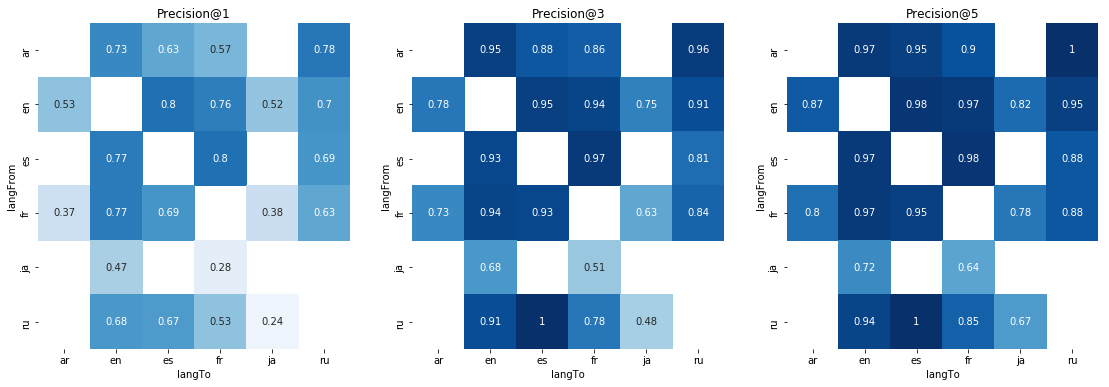

In [296]:
#convert results in matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
matrix = pd.DataFrame(finalResults)
matrix = matrix[matrix.Instances > 10]
fig, ax =plt.subplots(1,3,figsize=(19,6))

pl1 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo',values='Acc@1'),vmin=0.2, vmax=1 , cmap="Blues",cbar=False,annot=True, ax=ax[0])
pl1.set_title('Precision@1')
pl2 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Acc@3'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True, ax=ax[1])
pl2.set_title('Precision@3')
pl3 =sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Acc@5'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True,ax=ax[2])
pl3.set_title('Precision@5')
fig.savefig('WikiAlignmentsPrecision.png',bbox_inches='tight')

fig.show()


/usr/lib/python3/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


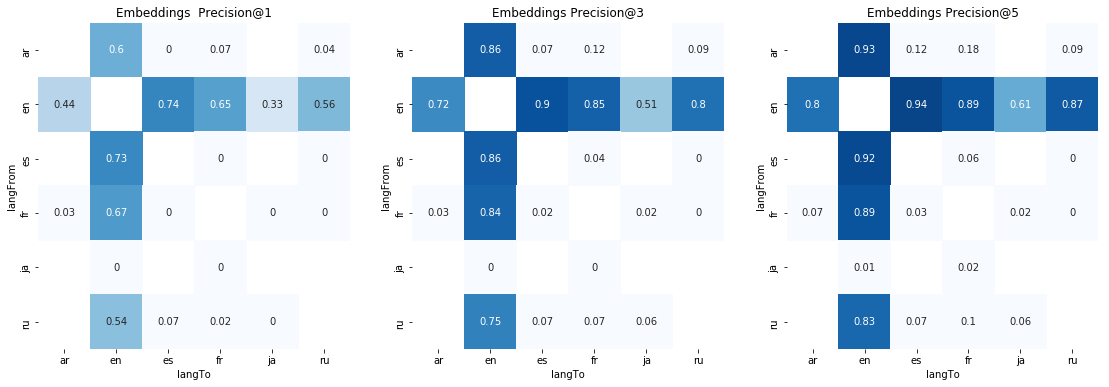

In [294]:
fig, ax =plt.subplots(1,3,figsize=(19,6))
pl1 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo',values='Baseline2 Acc@1').sort_values('langFrom'),vmin=0.2, vmax=1 , cmap="Blues",cbar=False,annot=True, ax=ax[0])
pl1.set_title('Embeddings  Precision@1')
pl2 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Baseline2 Acc@3'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True, ax=ax[1])
pl2.set_title('Embeddings Precision@3')
pl3 =sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Baseline2 Acc@5'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True,ax=ax[2])
pl3.set_title('Embeddings Precision@5')
fig.savefig('EmbeddingsPrecision.png')

fig.show()

In [295]:
?fig.savefig

In [302]:
print(matrix.pivot(index='langFrom',columns='langTo',values='Instances').fillna('-').to_latex())

\begin{tabular}{lllllll}
\toprule
langTo &   ar &   en &   es &   fr &   ja &   ru \\
langFrom &      &      &      &      &      &      \\
\midrule
ar       &    - &  382 &   59 &  136 &    - &   23 \\
en       &  213 &    - &  568 &  668 &  380 &  643 \\
es       &    - &  359 &    - &  335 &    - &   16 \\
fr       &   30 &  342 &  100 &    - &   60 &   43 \\
ja       &    - &   68 &    - &   47 &    - &    - \\
ru       &    - &  295 &   15 &  207 &   33 &    - \\
\bottomrule
\end{tabular}



/usr/lib/python3/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


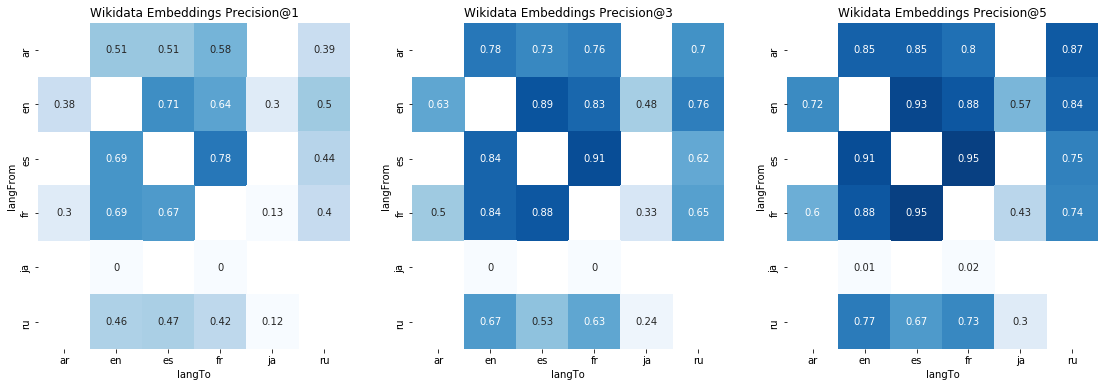

In [260]:
fig, ax =plt.subplots(1,3,figsize=(19,6))
pl1 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo',values='Baseline3 Acc@1'),vmin=0.2, vmax=1 , cmap="Blues",cbar=False,annot=True, ax=ax[0])
pl1.set_title('Wikidata Embeddings Precision@1')
pl2 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Baseline3 Acc@3'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True, ax=ax[1])
pl2.set_title('Wikidata Embeddings Precision@3')
pl3 =sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Baseline3 Acc@5'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True,ax=ax[2])
pl3.set_title('Wikidata Embeddings Precision@5')
fig.savefig('WikidataEmbeddingsPrecision.png')
fig.show()

In [423]:
t = [dict([ reversed(y) for y in x]) for x in featuresRank]
featuresRankDF = pd.DataFrame(t)
f = featuresRankDF.agg('mean')

print(pd.DataFrame(f.sort_values(ascending=False)[0:15]).round(decimals=3).to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
Distance\_my          &  0.120 \\
links\_jaccardMEAN    &  0.072 \\
LangTo\_tfidf\_normed  &  0.057 \\
Distance             &  0.052 \\
LangTo\_tfidfWeighted &  0.046 \\
rank                 &  0.045 \\
editDistance         &  0.044 \\
links\_jaccardSUM     &  0.040 \\
pos\_avg              &  0.031 \\
pos\_norm\_avg         &  0.025 \\
rank\_by\_count        &  0.025 \\
pos\_norm\_avg\_mult    &  0.023 \\
LangTo\_tfidf         &  0.021 \\
size\_median          &  0.017 \\
pos\_inv\_avg          &  0.017 \\
\bottomrule
\end{tabular}



## Get results including GoogleTranslate as Feature

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from itertools import permutations
K = 5

#features = ['LangTo_tfidf','LangFrom_tfidf','Distance','Distance_my',
#            'count','pos_norm_avg','pos_inv_avg','pos_norm_median',
#            'pos_avg_mult','size_median_mult','num_links_avg',
#           'links_jaccardMEAN', 'links_jaccardMEDIAN',
#           'links_jaccardSUM', 'links_commonMEAN', 'links_commonMEDIAN',
#           'links_commonSUM','editDistance','count_normed',
#            'Distance_myWeighted','DistanceWeighted','LangFrom_tfidfWeighted','LangTo_tfidfWeighted','rank']
            #'isAutomaticTranslationTo','isAutomaticTranslationFrom']
features = datasets['en']['es'].columns #could be any pair, all have the same columns
features = features.drop(['isTranslation','langFrom','langTo'])#,'isAutomaticTranslationTo','isAutomaticTranslationFrom'])

featuresRankWithGT = []
finalResults = []
accuracyPos = {}
for lang in langs:
    print(lang)
    tmpDF = []
    for lang1,data in datasets.items():
        if lang1 != lang:
            for lang2,dataset in data.items():
                if lang2 != lang:
                    tmpDF.append(dataset)    
    TrainData = pd.concat(tmpDF)
    X_train = TrainData[features]
    Y_train = TrainData['isTranslation']
    Model = XGBClassifier()
    Model.fit(X_train, Y_train)
    print(sorted(zip(Model.feature_importances_,X_train.columns),reverse=True))
    featuresRankWithGT.append(sorted(zip(Model.feature_importances_,X_train.columns),reverse=True))

    accuracyPos[lang] = {}
    for lang1,lang2 in permutations(langs,2):
        if lang1 == lang:
            try:
                recSheet = []

                TestData = prepareDataNew(lang1,lang2) # I need to create again the dataset, because the stored ones, are balanaced
                TestData  = TestData[TestData['count'] > 1] # PRE-FILTER, CANDIDATES NEWS TO COOCURR AT LEAST TWO (Arbitrary), THIS FOR REMOVING TYPOS AND NOISE

                X_test = TestData[features]
                test = TestData['isTranslation']
                y_prob= Model.predict_proba(X_test)
                TestData['prob'] = [pred[1] for pred in y_prob]
                output = []
                automaticTranslation = []

                #init accuracy dict
                accjustEmbeddings = {}
                accjustEmbeddingsMy = {}
                accuracy = {}
                accuracyPos[lang1][lang2] = {}          
                for i in range(1,K+1,2):
                    accuracy[i] = []
                    accjustEmbeddings[i] = []
                    accjustEmbeddingsMy[i] = []
                    accuracyPos[lang1][lang2][i] = []

                for secFrom,data in TestData.groupby('langFrom'):
                     if data['isTranslation'].any():
                        rank = data[TestData['isTranslation']]['rank_from'].iloc[0]
                        if data[TestData['isTranslation']]['isAutomaticTranslationFrom'].any() : #check if label is automatic translation
                            automaticTranslation.append(1)
                        else:
                            automaticTranslation.append(0)

                        for i in range(1,K+1,2):
                            #evaluation my approach
                            evaluation = data.sort_values('prob',ascending=False).iloc[0:i]['isTranslation'].any()
                       
                            if evaluation:
                                accuracy[i].append(1)
                                accuracyPos[lang1][lang2][i].append((rank,1))

                            else:
                                accuracy[i].append(0)
                                accuracyPos[lang1][lang2][i].append((rank,0))
                            #evaluating just embeedings

                            evaluationjustEmbeddings = data.sort_values('Distance',ascending=False).iloc[0:i]['isTranslation'].any()
                            evaluationjustEmbeddingsMy = data.sort_values('Distance_my',ascending=False).iloc[0:i]['isTranslation'].any()

                            if evaluationjustEmbeddings:
                                accjustEmbeddings[i].append(1)
                            else:
                                accjustEmbeddings[i].append(0)
                                       
                            if evaluationjustEmbeddingsMy:
                                accjustEmbeddingsMy[i].append(1)
                            else:
                                accjustEmbeddingsMy[i].append(0)    
                                       
                            if generateRecs == True:
                                    if numbOfCandidates == i:
                                        candidates = data.sort_values('prob',ascending=False)[['langTo','prob','rank_from']].iloc[0:5]
                                        candidates['secFrom'] =secFrom
                                        recSheet.append(candidates)
                            
                numOfInstances= len(automaticTranslation)

                if  numOfInstances> 0: #Here I'm just counting the number of sections with labels
                    acc = {'langFrom':lang1,'langTo':lang2,'Instances':numOfInstances}
                    acc['Baseline'] = round(sum(automaticTranslation)/len(automaticTranslation),2)
                    for i in range(1,K+1,2):
                        try:
                            acc['Acc@%s' % i] = round(sum(accuracy[i])/len(accuracy[i]),2)
                            acc['Baseline2 Acc@%s' % i] = round(sum(accjustEmbeddings[i])/len(accjustEmbeddings[i]),2)
                            acc['Baseline3 Acc@%s' % i] = round(sum(accjustEmbeddingsMy[i])/len(accjustEmbeddingsMy[i]),2)

                        except:
                            acc['Acc@%s' %i] = 0

                    print(lang1,lang2,acc)
                    finalResults.append(acc)
                    recSheet = pd.concat(recSheet)
                    recSheet.set_index('secFrom',inplace=True)
                    recSheet.sort_values(['rank_from','prob'],ascending=[True,False],inplace=True)
                    recSheet.to_excel('recSheets/%s_to_%s_withGoogle.xls' % (lang1,lang2))


            except Exception as ex:
                print('error',ex) #empty pairs
pd.DataFrame(finalResults).sort_values('langFrom').to_csv('predictorOutputWithAutomaticTranslationV2.csv')


ru


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.091883615, 'Distance_my'), (0.06891271, 'isAutomaticTranslationFrom'), (0.067381315, 'links_jaccardMEAN'), (0.058192957, 'rank'), (0.0474732, 'editDistance'), (0.0474732, 'LangTo_tfidf_normed'), (0.041347627, 'LangTo_tfidfWeighted'), (0.036753446, 'Distance'), (0.030627871, 'pos_norm_avg_mult'), (0.029096479, 'pos_avg'), (0.02603369, 'pos_norm_avg'), (0.02603369, 'LangTo_tfidf'), (0.022970904, 'rank_by_count'), (0.022970904, 'links_jaccardSUM'), (0.02143951, 'TotalCount'), (0.019908117, 'pos_avg_mult'), (0.019908117, 'LangFrom_tfidf'), (0.0153139355, 'size_rel_median'), (0.0153139355, 'pos_inv_avg'), (0.0153139355, 'num_links_median_mult'), (0.0153139355, 'links_commonMEDIAN'), (0.0153139355, 'fasttext_content_similarityMEAN'), (0.013782542, 'fasttext_content_similarityMEDIAN'), (0.012251149, 'num_links_median'), (0.012251149, 'link_dens_median_mult'), (0.010719755, 'size_median'), (0.010719755, 'num_links_avg_mult'), (0.010719755, 'links_commonMEAN'), (0.0091883615, 'size_avg'), (

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru ja {'Baseline3 Acc@1': 0.12, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.06, 'Baseline2 Acc@3': 0.06, 'Acc@3': 0.55, 'Baseline3 Acc@5': 0.3, 'Acc@1': 0.33, 'Baseline3 Acc@3': 0.24, 'langFrom': 'ru', 'langTo': 'ja', 'Baseline': 0.3, 'Instances': 33, 'Acc@5': 0.61}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru fr {'Baseline3 Acc@1': 0.42, 'Baseline2 Acc@1': 0.02, 'Baseline2 Acc@5': 0.1, 'Baseline2 Acc@3': 0.07, 'Acc@3': 0.83, 'Baseline3 Acc@5': 0.73, 'Acc@1': 0.62, 'Baseline3 Acc@3': 0.63, 'langFrom': 'ru', 'langTo': 'fr', 'Baseline': 0.42, 'Instances': 207, 'Acc@5': 0.9}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru ar {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 1.0, 'Baseline3 Acc@5': 0.0, 'Acc@1': 0.5, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ru', 'langTo': 'ar', 'Baseline': 0.5, 'Instances': 2, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru es {'Baseline3 Acc@1': 0.47, 'Baseline2 Acc@1': 0.07, 'Baseline2 Acc@5': 0.07, 'Baseline2 Acc@3': 0.07, 'Acc@3': 0.87, 'Baseline3 Acc@5': 0.67, 'Acc@1': 0.87, 'Baseline3 Acc@3': 0.53, 'langFrom': 'ru', 'langTo': 'es', 'Baseline': 0.67, 'Instances': 15, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ru en {'Baseline3 Acc@1': 0.46, 'Baseline2 Acc@1': 0.54, 'Baseline2 Acc@5': 0.83, 'Baseline2 Acc@3': 0.75, 'Acc@3': 0.92, 'Baseline3 Acc@5': 0.77, 'Acc@1': 0.77, 'Baseline3 Acc@3': 0.67, 'langFrom': 'ru', 'langTo': 'en', 'Baseline': 0.58, 'Instances': 295, 'Acc@5': 0.96}
ja


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.13500784, 'Distance_my'), (0.07378336, 'links_jaccardMEAN'), (0.06907378, 'isAutomaticTranslationFrom'), (0.054945055, 'rank'), (0.054945055, 'LangTo_tfidf_normed'), (0.043956045, 'LangTo_tfidfWeighted'), (0.042386185, 'Distance'), (0.039246466, 'editDistance'), (0.03453689, 'rank_by_count'), (0.029827315, 'link_dens_avg'), (0.028257458, 'pos_avg'), (0.02354788, 'links_jaccardSUM'), (0.020408163, 'size_median_mult'), (0.020408163, 'num_links_median_mult'), (0.018838305, 'LangTo_tfidf'), (0.017268445, 'num_links_median'), (0.015698588, 'pos_norm_avg_mult'), (0.015698588, 'pos_norm_avg'), (0.014128729, 'size_rel_median'), (0.014128729, 'pos_inv_avg'), (0.014128729, 'LangFrom_tfidf_normed'), (0.014128729, 'LangFrom_tfidf'), (0.01255887, 'links_rel_avg'), (0.01255887, 'fasttext_content_similarityMEDIAN'), (0.01255887, 'count'), (0.010989011, 'pos_norm_median_mult'), (0.0094191525, 'size_median'), (0.0094191525, 'size_avg'), (0.007849294, 'size_rel_avg'), (0.007849294, 'rank_mult'), (0.

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ja fr {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.02, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.6, 'Baseline3 Acc@5': 0.02, 'Acc@1': 0.45, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ja', 'langTo': 'fr', 'Baseline': 0.34, 'Instances': 47, 'Acc@5': 0.66}
error Cannot set a frame with no defined index and a value that cannot be converted to a Series


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ja es {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.89, 'Baseline3 Acc@5': 0.0, 'Acc@1': 0.56, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ja', 'langTo': 'es', 'Baseline': 0.56, 'Instances': 9, 'Acc@5': 0.89}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ja en {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.01, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.74, 'Baseline3 Acc@5': 0.01, 'Acc@1': 0.59, 'Baseline3 Acc@3': 0.0, 'langFrom': 'ja', 'langTo': 'en', 'Baseline': 0.21, 'Instances': 68, 'Acc@5': 0.78}
fr


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.09737249, 'Distance'), (0.08037094, 'links_jaccardMEAN'), (0.08037094, 'LangTo_tfidf_normed'), (0.061823804, 'isAutomaticTranslationFrom'), (0.05564142, 'rank'), (0.04018547, 'Distance_my'), (0.038639877, 'LangTo_tfidfWeighted'), (0.03709428, 'links_jaccardSUM'), (0.030911902, 'pos_norm_avg'), (0.030911902, 'editDistance'), (0.02472952, 'rank_by_count'), (0.023183925, 'num_links_median_mult'), (0.02163833, 'size_median'), (0.01854714, 'pos_inv_avg'), (0.01854714, 'num_links_median'), (0.017001545, 'pos_inv_avg_mult'), (0.017001545, 'fasttext_content_similarityMEAN'), (0.015455951, 'LangFrom_tfidf'), (0.013910355, 'pos_norm_avg_mult'), (0.013910355, 'links_rel_median_mult'), (0.013910355, 'TotalCount'), (0.013910355, 'LangFrom_tfidfWeighted'), (0.01236476, 'num_links_avg_mult'), (0.01236476, 'links_jaccardMEDIAN'), (0.01236476, 'count_normed'), (0.010819165, 'size_avg'), (0.010819165, 'pos_norm_median'), (0.010819165, 'pos_avg'), (0.010819165, 'fasttext_content_similarityMEDIAN'), (

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr ru {'Baseline3 Acc@1': 0.4, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.84, 'Baseline3 Acc@5': 0.74, 'Acc@1': 0.67, 'Baseline3 Acc@3': 0.65, 'langFrom': 'fr', 'langTo': 'ru', 'Baseline': 0.12, 'Instances': 43, 'Acc@5': 0.95}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr ja {'Baseline3 Acc@1': 0.13, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.02, 'Baseline2 Acc@3': 0.02, 'Acc@3': 0.73, 'Baseline3 Acc@5': 0.43, 'Acc@1': 0.48, 'Baseline3 Acc@3': 0.33, 'langFrom': 'fr', 'langTo': 'ja', 'Baseline': 0.32, 'Instances': 60, 'Acc@5': 0.85}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr ar {'Baseline3 Acc@1': 0.3, 'Baseline2 Acc@1': 0.03, 'Baseline2 Acc@5': 0.07, 'Baseline2 Acc@3': 0.03, 'Acc@3': 0.73, 'Baseline3 Acc@5': 0.6, 'Acc@1': 0.33, 'Baseline3 Acc@3': 0.5, 'langFrom': 'fr', 'langTo': 'ar', 'Baseline': 0.17, 'Instances': 30, 'Acc@5': 0.83}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr es {'Baseline3 Acc@1': 0.67, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.03, 'Baseline2 Acc@3': 0.02, 'Acc@3': 0.93, 'Baseline3 Acc@5': 0.95, 'Acc@1': 0.75, 'Baseline3 Acc@3': 0.88, 'langFrom': 'fr', 'langTo': 'es', 'Baseline': 0.18, 'Instances': 100, 'Acc@5': 0.96}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


fr en {'Baseline3 Acc@1': 0.69, 'Baseline2 Acc@1': 0.67, 'Baseline2 Acc@5': 0.89, 'Baseline2 Acc@3': 0.84, 'Acc@3': 0.94, 'Baseline3 Acc@5': 0.88, 'Acc@1': 0.82, 'Baseline3 Acc@3': 0.84, 'langFrom': 'fr', 'langTo': 'en', 'Baseline': 0.58, 'Instances': 342, 'Acc@5': 0.97}
ar


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.12210201, 'Distance_my'), (0.061823804, 'isAutomaticTranslationFrom'), (0.060278207, 'LangTo_tfidfWeighted'), (0.057187017, 'links_jaccardMEAN'), (0.04945904, 'rank'), (0.04945904, 'editDistance'), (0.038639877, 'LangTo_tfidf_normed'), (0.035548687, 'links_jaccardSUM'), (0.03400309, 'Distance'), (0.02782071, 'pos_avg'), (0.026275115, 'links_jaccardMEDIAN'), (0.023183925, 'size_median'), (0.02163833, 'pos_avg_mult'), (0.017001545, 'pos_norm_avg_mult'), (0.017001545, 'pos_norm_avg'), (0.017001545, 'LangTo_tfidf'), (0.015455951, 'size_rel_avg'), (0.015455951, 'rank_by_count'), (0.013910355, 'LangFrom_tfidfWeighted'), (0.013910355, 'DistanceWeighted'), (0.01236476, 'size_rel_median'), (0.01236476, 'size_median_mult'), (0.01236476, 'size_avg_mult'), (0.01236476, 'num_links_median_mult'), (0.01236476, 'links_commonMEDIAN'), (0.01236476, 'count'), (0.01236476, 'LangFrom_tfidf_normed'), (0.01236476, 'LangFrom_tfidf'), (0.010819165, 'pos_inv_avg'), (0.010819165, 'num_links_median'), (0.0108

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar ru {'Baseline3 Acc@1': 0.39, 'Baseline2 Acc@1': 0.04, 'Baseline2 Acc@5': 0.09, 'Baseline2 Acc@3': 0.09, 'Acc@3': 0.91, 'Baseline3 Acc@5': 0.87, 'Acc@1': 0.83, 'Baseline3 Acc@3': 0.7, 'langFrom': 'ar', 'langTo': 'ru', 'Baseline': 0.09, 'Instances': 23, 'Acc@5': 0.96}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar ja {'Baseline3 Acc@1': 0.3, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.6, 'Baseline3 Acc@5': 0.6, 'Acc@1': 0.3, 'Baseline3 Acc@3': 0.3, 'langFrom': 'ar', 'langTo': 'ja', 'Baseline': 0.3, 'Instances': 10, 'Acc@5': 0.8}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar fr {'Baseline3 Acc@1': 0.58, 'Baseline2 Acc@1': 0.07, 'Baseline2 Acc@5': 0.18, 'Baseline2 Acc@3': 0.12, 'Acc@3': 0.9, 'Baseline3 Acc@5': 0.8, 'Acc@1': 0.71, 'Baseline3 Acc@3': 0.76, 'langFrom': 'ar', 'langTo': 'fr', 'Baseline': 0.45, 'Instances': 136, 'Acc@5': 0.93}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar es {'Baseline3 Acc@1': 0.51, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.12, 'Baseline2 Acc@3': 0.07, 'Acc@3': 0.9, 'Baseline3 Acc@5': 0.85, 'Acc@1': 0.68, 'Baseline3 Acc@3': 0.73, 'langFrom': 'ar', 'langTo': 'es', 'Baseline': 0.58, 'Instances': 59, 'Acc@5': 0.97}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


ar en {'Baseline3 Acc@1': 0.51, 'Baseline2 Acc@1': 0.6, 'Baseline2 Acc@5': 0.93, 'Baseline2 Acc@3': 0.86, 'Acc@3': 0.95, 'Baseline3 Acc@5': 0.85, 'Acc@1': 0.76, 'Baseline3 Acc@3': 0.78, 'langFrom': 'ar', 'langTo': 'en', 'Baseline': 0.35, 'Instances': 382, 'Acc@5': 0.97}
es


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.10429448, 'Distance_my'), (0.07055215, 'links_jaccardMEAN'), (0.07055215, 'isAutomaticTranslationFrom'), (0.06288344, 'Distance'), (0.061349694, 'rank'), (0.058282208, 'LangTo_tfidf_normed'), (0.042944785, 'links_jaccardSUM'), (0.0398773, 'LangTo_tfidfWeighted'), (0.035276074, 'pos_avg'), (0.024539877, 'pos_avg_mult'), (0.024539877, 'LangTo_tfidf'), (0.023006136, 'pos_norm_avg_mult'), (0.023006136, 'pos_inv_avg'), (0.018404908, 'pos_inv_avg_mult'), (0.016871165, 'pos_norm_avg'), (0.016871165, 'links_jaccardMEDIAN'), (0.016871165, 'editDistance'), (0.016871165, 'TotalCount'), (0.015337423, 'size_rel_median'), (0.015337423, 'rank_by_count'), (0.015337423, 'LangFrom_tfidf'), (0.013803681, 'size_median'), (0.012269938, 'pos_inv_median'), (0.012269938, 'LangFrom_tfidfWeighted'), (0.010736196, 'size_rel_avg'), (0.010736196, 'size_median_mult'), (0.010736196, 'num_links_median_mult'), (0.009202454, 'num_links_median'), (0.009202454, 'links_commonSUM'), (0.009202454, 'fasttext_content_simi

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


es ru {'Baseline3 Acc@1': 0.44, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 0.81, 'Baseline3 Acc@5': 0.75, 'Acc@1': 0.69, 'Baseline3 Acc@3': 0.62, 'langFrom': 'es', 'langTo': 'ru', 'Baseline': 0.19, 'Instances': 16, 'Acc@5': 0.88}
es ja {'Baseline3 Acc@1': 0.0, 'Baseline2 Acc@1': 0.0, 'Baseline2 Acc@5': 0.0, 'Baseline2 Acc@3': 0.0, 'Acc@3': 1.0, 'Baseline3 Acc@5': 0.0, 'Acc@1': 0.0, 'Baseline3 Acc@3': 0.0, 'langFrom': 'es', 'langTo': 'ja', 'Baseline': 0.0, 'Instances': 1, 'Acc@5': 1.0}


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


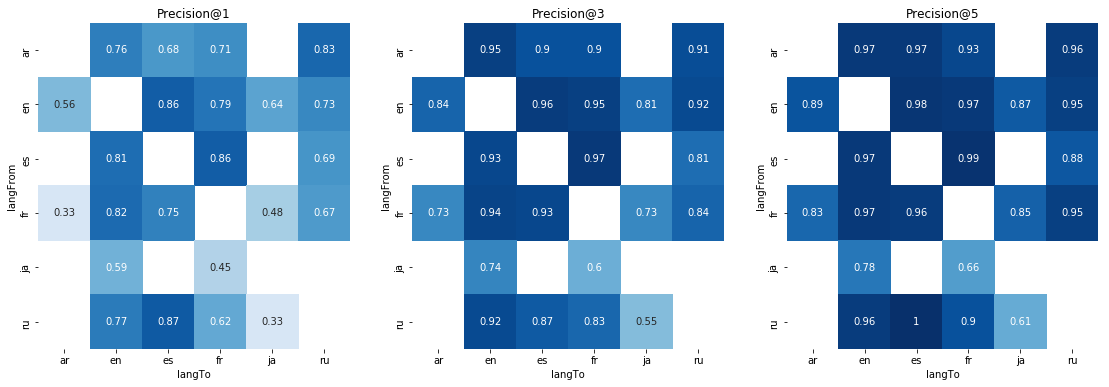

In [384]:
#convert results in matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
matrix = pd.DataFrame(finalResults)
matrix = matrix[matrix.Instances > 10]
fig, ax =plt.subplots(1,3,figsize=(19,6))

pl1 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo',values='Acc@1'),vmin=0.2, vmax=1 , cmap="Blues",cbar=False,annot=True, ax=ax[0])
pl1.set_title('Precision@1')
pl2 = sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Acc@3'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True, ax=ax[1])
pl2.set_title('Precision@3')
pl3 =sns.heatmap(matrix.pivot(index='langFrom',columns='langTo', values='Acc@5'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True,ax=ax[2])
pl3.set_title('Precision@5')
#fig.savefig('WikiAlignmentsWithGTPrecision.png',bbox_inches='tight')

#fig.show()

In [429]:
TrainData.corr()['isTranslation'].sort_values()

rank_by_count                       -0.520585
rank_by_LangTo_tfidf                -0.520585
editDistance                        -0.380979
TotalCount                          -0.312997
LangFrom_tfidf                      -0.305469
LangFrom_tfidf_normed               -0.302984
rank_mult                           -0.181803
links_rel_avg                       -0.173122
size_rel_avg                        -0.145983
pos_norm_avg                        -0.124642
link_dens_avg                       -0.116147
pos_norm_median                     -0.099866
pos_norm_std                        -0.099866
pos_std_mult                        -0.084907
pos_median_mult                     -0.084907
link_dens_std                       -0.077988
link_dens_median                    -0.077988
pos_avg_mult                        -0.076091
size_std_mult                       -0.075815
size_median_mult                    -0.075815
rank_by_LangFrom_tfidf              -0.066605
pos_inv_std_mult                  

In [414]:
t = [dict([ reversed(y) for y in x]) for x in featuresRankWithGT]
featuresRankDF = pd.DataFrame(t)
f = featuresRankDF.agg('mean')

print(pd.DataFrame(f.sort_values(ascending=False)[0:15]).round(decimals=3).to_latex())

\begin{tabular}{lr}
\toprule
{} &      0 \\
\midrule
Distance\_my                &  0.108 \\
links\_jaccardMEAN          &  0.067 \\
isAutomaticTranslationFrom &  0.065 \\
rank                       &  0.052 \\
LangTo\_tfidf\_normed        &  0.051 \\
Distance                   &  0.048 \\
LangTo\_tfidfWeighted       &  0.042 \\
editDistance               &  0.037 \\
links\_jaccardSUM           &  0.036 \\
pos\_avg                    &  0.030 \\
pos\_norm\_avg\_mult          &  0.023 \\
pos\_norm\_avg               &  0.021 \\
rank\_by\_count              &  0.021 \\
LangTo\_tfidf               &  0.019 \\
size\_median                &  0.017 \\
\bottomrule
\end{tabular}



In [421]:
f.sort_values(ascending=False).index


Index(['Distance_my', 'links_jaccardMEAN', 'isAutomaticTranslationFrom',
       'rank', 'LangTo_tfidf_normed', 'Distance', 'LangTo_tfidfWeighted',
       'editDistance', 'links_jaccardSUM', 'pos_avg', 'pos_norm_avg_mult',
       'pos_norm_avg', 'rank_by_count', 'LangTo_tfidf', 'size_median',
       'pos_inv_avg', 'pos_avg_mult', 'LangFrom_tfidf', 'links_jaccardMEDIAN',
       'num_links_median_mult', 'size_rel_median', 'num_links_median',
       'fasttext_content_similarityMEAN', 'link_dens_avg',
       'fasttext_content_similarityMEDIAN', 'size_median_mult',
       'pos_inv_avg_mult', 'LangFrom_tfidf_normed', 'TotalCount', 'count',
       'LangFrom_tfidfWeighted', 'size_rel_avg', 'size_avg',
       'pos_norm_median_mult', 'links_rel_avg', 'links_commonMEDIAN',
       'num_links_avg_mult', 'pos_inv_median', 'link_dens_median_mult',
       'link_dens_avg_mult', 'Distance_myWeighted', 'DistanceWeighted',
       'num_links_avg', 'size_avg_mult', 'links_commonMEAN',
       'links_rel_media

In [ ]:
#convert results in matrix
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
matrixGT = pd.DataFrame(finalResults)
matrixGT = matrixGT[matrixGT.Instances > 10]
fig, ax =plt.subplots(1,3,figsize=(19,6))

pl1 = sns.heatmap(matrixGT.pivot(index='langFrom',columns='langTo',values='Acc@1'),vmin=0.2, vmax=1 , cmap="Blues",cbar=False,annot=True, ax=ax[0])
pl1.set_title('Precision@1')
pl2 = sns.heatmap(matrixGT.pivot(index='langFrom',columns='langTo', values='Acc@3'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True, ax=ax[1])
pl2.set_title('Precision@3')
pl3 =sns.heatmap(matrixGT.pivot(index='langFrom',columns='langTo', values='Acc@5'),vmin=0.2, vmax=1, cmap="Blues",cbar=False,annot=True,ax=ax[2])
pl3.set_title('Precision@5')
fig.savefig('WikiAlignmentsPrecisionWithGT.png',bbox_inches='tight')

fig.show()


In [109]:
#Testing just one pair en es
#Test precision at K

features = TrainData.columns 
features = features.drop(['isTranslation','langFrom','langTo','isAutomaticTranslationTo','isAutomaticTranslationFrom'])

K = 5
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from itertools import permutations

for lang in ['en']:#langs:
    print(lang)
    tmpDF = []
    for lang1,data in datasets.items():
        if lang1 != lang:
            for lang2,dataset in data.items():
                if lang2 != lang:
                    tmpDF.append(dataset)    
    TrainData = pd.concat(tmpDF)
    X_train = TrainData[features]
    Y_train = TrainData['isTranslation']
    Model = XGBClassifier()
    Model.fit(X_train, Y_train)
    print(sorted(zip(Model.feature_importances_,X_train.columns),reverse=True))
    for lang1,lang2 in [('en','fr')]: #permutations(langs,2):
        if lang1 == lang:
                TestData = prepareDataNew(lang1,lang2) # I need to create again the dataset, because the stored ones, are balanaced
                TestData  = TestData[TestData['count'] > 1] # PRE-FILTER, CANDIDATES NEWS TO COOCURR AT LEAST FIVE (Arbitrary), THIS FOR REMOVING TYPOS AND NOISE
                X_test = TestData[features]
                test = TestData['isTranslation']
                y_prob= Model.predict_proba(X_test)
                TestData['prob'] = [pred[1] for pred in y_prob]
                output = []
                automaticTranslation = []
                #init accuracy dict
                for i in range(1,K+1,2):
                    accuracy[i] = []
                for secFrom,data in TestData.groupby('langFrom'):
                     if data['isTranslation'].any():
                        if data[TestData['isTranslation']]['isAutomaticTranslationFrom'].any(): #check if label is automatic translation
                            automaticTranslation.append(1)
                        else:
                            automaticTranslation.append(0)

                        for i in range(1,K+1,2):
                            evaluation = data.sort_values('prob',ascending=False).iloc[0:i]['isTranslation'].any()
                        
                            if evaluation:
                                accuracy[i].append(1)
                            else:
                                accuracy[i].append(0)
                        
                        
                        
                        #### This is for create spreadshets with examples
                        #data = data.sort_values('prob',ascending=False)[['langTo','prob','count','count_normed','isTranslation']]
                        #data.reset_index(inplace=True)
                        #data['rank'] = data.index +1 
                        #candidates = data.iloc[0:2]
                        #label = data[data['isTranslation'] == True]
                        #candidates = pd.concat([candidates,label])
                        #candidates['secFrom'] =secFrom
                        #candidates.set_index('secFrom',inplace=True)
                        #candidates.drop_duplicates(inplace=True)
                        #del(candidates['index'])
                        #output.append(candidates)
                        
                print('Automatic Translation',sum(automaticTranslation)/len(automaticTranslation))
                acc = {}
                for i in range(1,K+1,2):
                    try:

                        acc[i] = sum(accuracy[i])/len(accuracy[i])
                    except:
                        acc[i] = 0
                    print('Accuracy@%s' % i,lang1,lang2, acc[i])
                #finalResults.append((lang1,lang2,round(acc,3)))
                #spreadsheetOutput = pd.concat(output)
                #spreadsheetOutput.rename(columns={'isTranslation':'label'},inplace=True)
                #spreadsheetOutput.to_excel('spreadsheetOutput/%s_to_%s.xls' % (lang1,lang2))

pd.DataFrame(finalResults).sort_values('langFrom').to_csv('predictorOutputWithAutomaticTranslationV2.csv')


en


/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



[(0.15615141, 'Distance_my'), (0.07097792, 'LangTo_tfidf'), (0.06782334, 'rank'), (0.066246055, 'editDistance'), (0.06309148, 'links_jaccardMEAN'), (0.0488959, 'links_jaccardSUM'), (0.036277603, 'pos_avg'), (0.03154574, 'rank_by_LangTo_tfidf'), (0.03154574, 'pos_norm_avg'), (0.03154574, 'LangFrom_tfidf'), (0.029968454, 'LangTo_tfidfWeighted'), (0.02208202, 'TotalCount_mult'), (0.020504732, 'size_median_mult'), (0.018927446, 'size_median'), (0.018927446, 'Distance_myWeighted'), (0.01577287, 'size_rel_avg'), (0.01577287, 'num_links_avg'), (0.01577287, 'TotalCount'), (0.014195584, 'size_rel_avg_mult'), (0.014195584, 'pos_avg_mult'), (0.014195584, 'num_links_avg_mult'), (0.012618297, 'pos_norm_avg_mult'), (0.01104101, 'size_avg'), (0.01104101, 'pos_norm_median'), (0.01104101, 'LangFrom_tfidfWeighted'), (0.009463723, 'size_rel_median'), (0.009463723, 'num_links_median'), (0.009463723, 'link_dens_avg_mult'), (0.009463723, 'link_dens_avg'), (0.009463723, 'DistanceWeighted'), (0.007886435, 'po

/home/dsaez/venv/lib/python3.5/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Automatic Translation 0.5774647887323944
Accuracy@1 en fr 0.6901408450704225
Accuracy@3 en fr 0.8886043533930857
Accuracy@5 en fr 0.9321382842509603


In [539]:
#counting the number of candidates per pair
for lang1,lang2 in permutations(langs,2):
    try:
        TestData=prepareDataNew(lang1,lang2)
    
        print(lang1,lang2,len(TestData.langTo.unique()))
        
    except:
        pass

ru ja 33851
ru fr 57202
ru ar 20047
ru es 44546
ru en 77783
ja fr 43870
ja es 33855
ja en 59907
fr ru 42270
fr ja 32825
fr ar 25961
fr es 47675
fr en 77446
ar ru 11848
ar ja 6921
ar fr 25000
ar es 15462
ar en 35803
es ru 45192
es ja 4833
es fr 58216
es ar 5025
es en 77383
en ru 66571
en ja 50258
en fr 72221
en ar 41629


In [572]:
import matplotlib.pyplot as plt
def plotAccRank(results,K,title='',M=False):

    for label,result in results.items():
        posX = []
        posY = []
        posVal = 0
        for n,(rank,val) in enumerate(sorted(result[K])):
            posVal += val
            posY.append(posVal/(n+1))
            posX.append(rank)
        plt.plot(posX,posY,label=label)
    plt.legend()
    if not M: M=max(posX)
    plt.xlim(0,M)
    plt.title(title)
    plt.xlabel('Section Popularity (Ranking)')
    plt.ylabel('Mapping Accuracy at %s' % K)

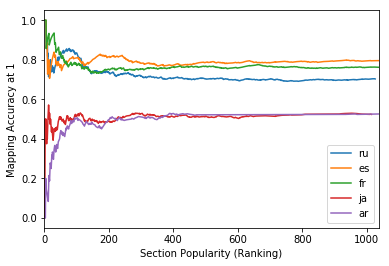

In [573]:
plotAccRank(accuracyPos['en'],1)


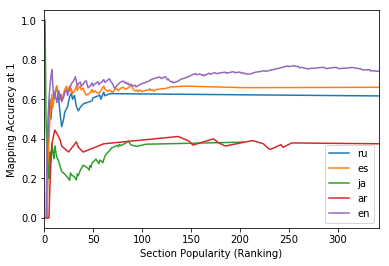

In [566]:
plotAccRank(accuracyPos['fr'],1)


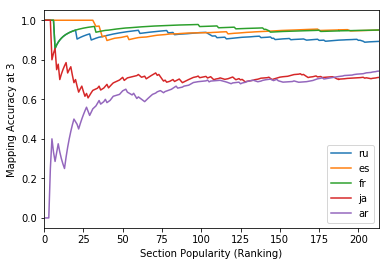

In [567]:
plotAccRank(accuracyPos['en'],3)


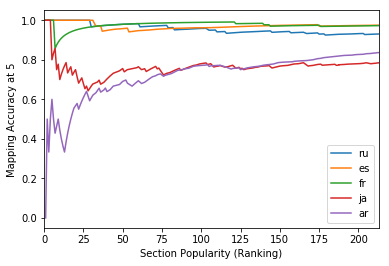

In [569]:
plotAccRank(accuracyPos['en'],5)


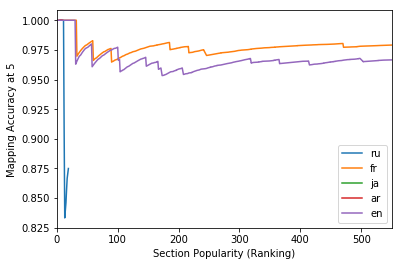

In [574]:
plotAccRank(accuracyPos['es'],K=5)


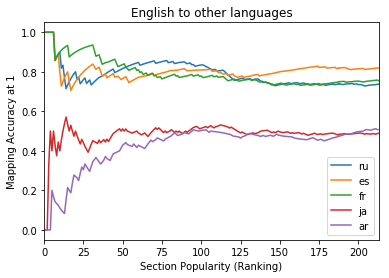

In [571]:
plotAccRank(accuracyPos['en'],1,'English to other languages')


In [ ]:
plotAccRank(accuracyPosAT['ar'],1,'Arabic to Other Languages + GT')


In [ ]:
plotAccRank(accuracyPosAT['en'],1,'English to Other Languages + GT')


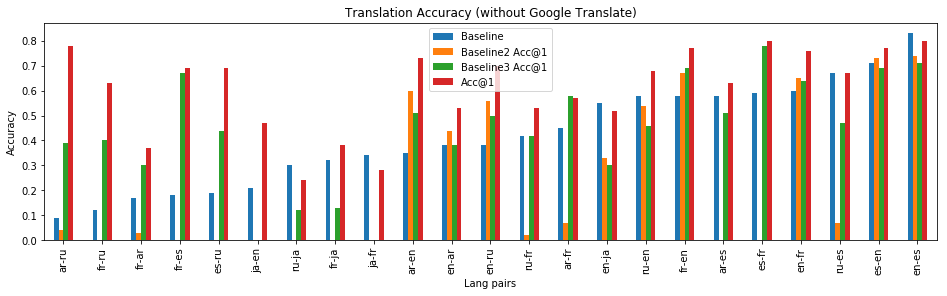

In [431]:
r = pd.DataFrame(finalResults)
r['langPair'] = r['langFrom'] + '-' + r['langTo']
r.set_index('langPair',inplace=True)
r['improvementGT'] = r['Acc@1']-r['Baseline']
r['improvementEmbeddings'] = r['Acc@1']-r['Baseline2 Acc@1']
r['improvementEmbeddings@3'] = r['Acc@3']-r['Baseline2 Acc@3']
r['improvementWikidatavsNormalEmbeddings'] = r['Baseline3 Acc@1']-r['Baseline2 Acc@1']
r['improvementWikidatavsNormalEmbeddings@5'] = r['Baseline3 Acc@5']-r['Baseline2 Acc@5']

g = r[r.Instances > 10].sort_values('Baseline',ascending=True)[['Baseline','Baseline2 Acc@1','Baseline3 Acc@1','Acc@1']].plot(kind='bar',sort_columns=True,figsize=(16,4))
g.set_ylabel('Accuracy')
g.set_xlabel('Lang pairs')
g.set_title('Translation Accuracy (without Google Translate)')
fig = g.get_figure()
fig.savefig("translationAccuracyWithoutGT.png")


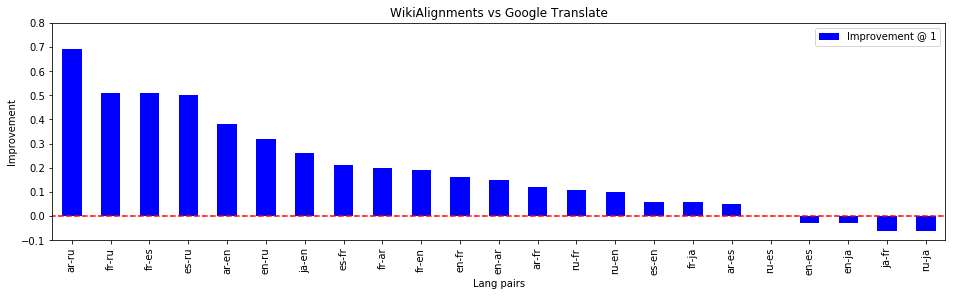

In [521]:
from matplotlib import cm

r = pd.DataFrame(finalResults)
r['langPair'] = r['langFrom'] + '-' + r['langTo']
r.set_index('langPair',inplace=True)
r['improvementGT'] = r['Acc@1']-r['Baseline']
r['improvementEmbeddings'] = r['Acc@1']-r['Baseline2 Acc@1']
r['improvementEmbeddings@3'] = r['Acc@3']-r['Baseline2 Acc@3']
r['improvementEmbeddings@5'] = r['Acc@3']-r['Baseline2 Acc@5']

r['improvementWikidatavsNormalEmbeddings'] = r['Baseline3 Acc@1']-r['Baseline2 Acc@1']
r['improvementWikidatavsNormalEmbeddings@5'] = r['Baseline3 Acc@5']-r['Baseline2 Acc@5']


g = r[r.Instances > 10].sort_values('improvementGT',ascending=False)[['improvementGT']].plot(kind='bar',sort_columns=True,figsize=(16,4),cmap=cm.get_cmap('winter'))
g.set_ylabel('Improvement')
g.set_xlabel('Lang pairs')
g.set_title('WikiAlignments vs Google Translate')
g.legend(['Improvement @ 1'])

g.set_ylim(-.1,.8)
g.hlines(xmin=-2,xmax=len(r),y=0,colors='r',linestyles='--')
fig = g.get_figure()
fig.savefig("translationImprovementOverGTWithoutGT.png",bbox_inches='tight')


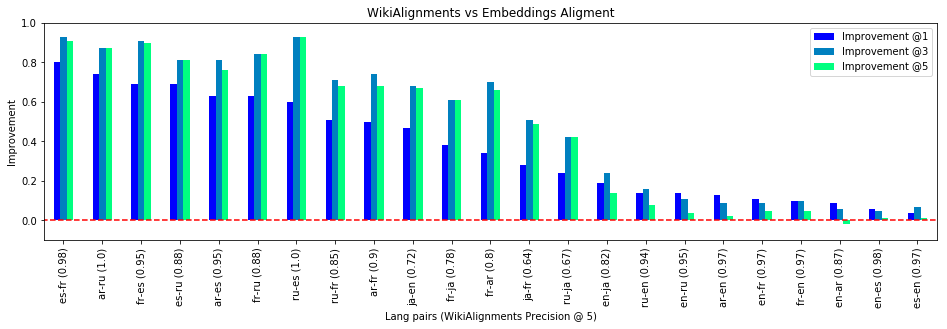

In [519]:
from matplotlib import cm


g = r[r.Instances > 10].sort_values('improvementEmbeddings',ascending=False)[['improvementEmbeddings','improvementEmbeddings@3','improvementEmbeddings@5']].plot(kind='bar',sort_columns=True,figsize=(16,4), cmap=cm.get_cmap('winter'))


valuesAcc= r[r.Instances > 10].sort_values('improvementEmbeddings',ascending=False)['Acc@5']



g.set_ylabel('Improvement')
g.set_xlabel('Lang pairs (WikiAlignments Precision @ 5)')
g.legend(['Improvement @1','Improvement @3','Improvement @5'])

g.set_title('WikiAlignments vs Embeddings Aligment')
g.set_ylim(-.1,1)
g.hlines(xmin=-2,xmax=len(r),y=0,colors='r',linestyles='--')

g.set_xticklabels([ '%s (%s)' % (label.get_text(),precision) for label,precision in  zip(g.get_xticklabels(),valuesAcc) ])


fig = g.get_figure()
fig.savefig("translationImprovementOverEmbeddingsWithoutGTMutipleK.png",bbox_inches='tight')

In [490]:
x = g.get_xticklabels()

In [499]:
y= x[0]
y.get_text()

'es-fr'

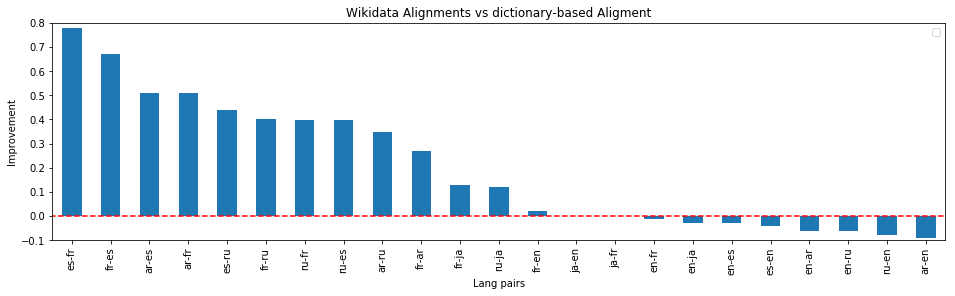

In [448]:
g = r[r.Instances > 10].sort_values('improvementWikidatavsNormalEmbeddings',ascending=False)[['improvementWikidatavsNormalEmbeddings']].plot(kind='bar',sort_columns=True,figsize=(16,4))
g.legend('')
g.set_ylabel('Improvement')
g.set_xlabel('Lang pairs')
g.set_title('Wikidata Alignments vs dictionary-based Aligment')
g.set_ylim(-0.1,.8)
g.hlines(xmin=-2,xmax=len(r),y=0,colors='r',linestyles='--')
fig = g.get_figure()


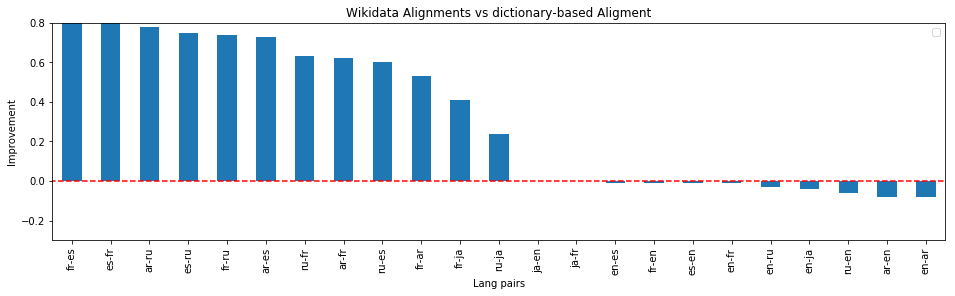

In [293]:
g = r[r.Instances > 10].sort_values('improvementWikidatavsNormalEmbeddings@5',ascending=False)[['improvementWikidatavsNormalEmbeddings@5']].plot(kind='bar',sort_columns=True,figsize=(16,4))
g.legend('')
g.set_ylabel('Improvement')
g.set_xlabel('Lang pairs')
g.set_title('Wikidata Alignments vs dictionary-based Aligment')
g.set_ylim(-.3,.8)
g.hlines(xmin=-2,xmax=len(r),y=0,colors='r',linestyles='--')
fig = g.get_figure()

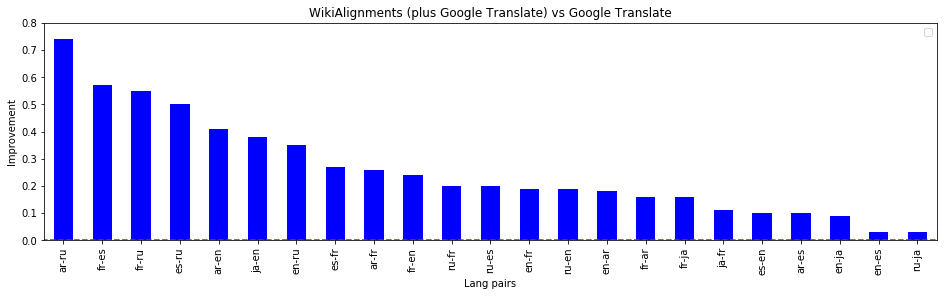

In [575]:
## Plots with GT

r = pd.read_csv('predictorOutputWithAutomaticTranslationV2.csv')
r['langPair'] = r['langFrom'] + '-' + r['langTo']
r.set_index('langPair',inplace=True)
r['improvementGT'] = r['Acc@1']-r['Baseline']
r['improvementEmbeddings'] = r['Acc@1']-r['Baseline2 Acc@1']
r['improvementEmbeddings@3'] = r['Acc@3']-r['Baseline2 Acc@3']
r['improvementWikidatavsNormalEmbeddings'] = r['Baseline3 Acc@1']-r['Baseline2 Acc@1']
r['improvementWikidatavsNormalEmbeddings@5'] = r['Baseline3 Acc@5']-r['Baseline2 Acc@5']
g = r[r.Instances > 10].sort_values('improvementGT',ascending=False)[['improvementGT']].plot(kind='bar',sort_columns=True,figsize=(16,4),cmap=cm.get_cmap('winter'))
g.set_ylabel('Improvement')
g.set_xlabel('Lang pairs')
g.set_title('WikiAlignments (plus Google Translate) vs Google Translate')
g.legend('')

g.set_ylim(0,.8)
g.hlines(xmin=-2,xmax=len(r),y=0,colors='r',linestyles='--')
fig = g.get_figure()
fig.savefig("translationImprovementOverGTWithGT.png",bbox_inches='tight')
